In [0]:
# Unmount the storage
dbutils.fs.unmount("/mnt/IkigaiGuide")

/mnt/IkigaiGuide has been unmounted.


True

In [0]:
dbutils.fs.mount(
  source = "wasbs://ikigai-guide-data@ikigaiguideunidata.blob.core.windows.net",
  mount_point = "/mnt/IkigaiGuide",
  extra_configs = {"fs.azure.account.key.ikigaiguideunidata.blob.core.windows.net": "+tu0bU1lIVTvT5xpfonfXJ6gJqH4a8pU8/MOTtGLD0l5Tkh/Qf8oGcyOvVBWCsoRzjiQ9cN6vOzb+AStfhQGmw=="})


True

In [0]:
# List files in the mounted directory to verify the mount
display(dbutils.fs.ls("/mnt/IkigaiGuide"))


path,name,size,modificationTime
dbfs:/mnt/IkigaiGuide/ikigai-raw-data/,ikigai-raw-data/,0,0
dbfs:/mnt/IkigaiGuide/ikigai-transformed-data/,ikigai-transformed-data/,0,0


In [0]:
# Adjusted file path to point to the specific file inside the ikigai-raw-data folder
file_path = "/mnt/IkigaiGuide/ikigai-raw-data/TIMES.csv"

# Load the dataset
TIMES = spark.read.option("header", "true").option("inferSchema", "true").csv(file_path)

# Display the first few rows of the DataFrame to understand its structure
TIMES.show()


+----+--------------------+--------------+-------------------+---------------+--------------------+---------------+--------------------+----------------+---------------------+----------------------+---------------------------+----------------------------+---------------------------------+--------------+------------+--------------------+------+--------------+---------------------+-------------------------+----------------------+-----------------------+--------------------+--------------------+------+------------+--------+--------------------+
|rank|                name|scores_overall|scores_overall_rank|scores_teaching|scores_teaching_rank|scores_research|scores_research_rank|scores_citations|scores_citations_rank|scores_industry_income|scores_industry_income_rank|scores_international_outlook|scores_international_outlook_rank|   record_type|member_level|                 url|   nid|      location|stats_number_students|stats_student_staff_ratio|stats_pc_intl_students|stats_female_male_rat

In [0]:
# Display the data types of each column in the TIMES DataFrame
TIMES.dtypes


[('rank', 'string'),
 ('name', 'string'),
 ('scores_overall', 'string'),
 ('scores_overall_rank', 'int'),
 ('scores_teaching', 'string'),
 ('scores_teaching_rank', 'int'),
 ('scores_research', 'string'),
 ('scores_research_rank', 'int'),
 ('scores_citations', 'string'),
 ('scores_citations_rank', 'int'),
 ('scores_industry_income', 'string'),
 ('scores_industry_income_rank', 'int'),
 ('scores_international_outlook', 'string'),
 ('scores_international_outlook_rank', 'int'),
 ('record_type', 'string'),
 ('member_level', 'int'),
 ('url', 'string'),
 ('nid', 'int'),
 ('location', 'string'),
 ('stats_number_students', 'string'),
 ('stats_student_staff_ratio', 'double'),
 ('stats_pc_intl_students', 'string'),
 ('stats_female_male_ratio', 'string'),
 ('aliases', 'string'),
 ('subjects_offered', 'string'),
 ('closed', 'boolean'),
 ('unaccredited', 'boolean'),
 ('disabled', 'boolean'),
 ('website_url', 'string')]

In [0]:
from pyspark.sql.functions import col, when, count

# Count missing values for each column
missing_value_counts = TIMES.select([
    count(
        when(
            col(c).isNull() | (col(c) == ""), c
        )
    ).alias(c) for c in TIMES.columns
])

missing_value_counts.show()


+----+----+--------------+-------------------+---------------+--------------------+---------------+--------------------+----------------+---------------------+----------------------+---------------------------+----------------------------+---------------------------------+-----------+------------+---+---+--------+---------------------+-------------------------+----------------------+-----------------------+-------+----------------+------+------------+--------+-----------+
|rank|name|scores_overall|scores_overall_rank|scores_teaching|scores_teaching_rank|scores_research|scores_research_rank|scores_citations|scores_citations_rank|scores_industry_income|scores_industry_income_rank|scores_international_outlook|scores_international_outlook_rank|record_type|member_level|url|nid|location|stats_number_students|stats_student_staff_ratio|stats_pc_intl_students|stats_female_male_ratio|aliases|subjects_offered|closed|unaccredited|disabled|website_url|
+----+----+--------------+-------------------+

In [0]:
from pyspark.sql.functions import col, lit
from pyspark.sql.window import Window
from pyspark.sql.functions import rank

# Step 1: Calculate the mode
mode_df = TIMES.groupBy("stats_female_male_ratio").count()\
               .withColumn("rank", rank().over(Window.orderBy(col("count").desc())))\
               .filter(col("rank") == 1).drop("rank")

mode_value = mode_df.collect()[0]["stats_female_male_ratio"]

# Step 2: Fill missing values with the mode
TIMES_filled = TIMES.na.fill({"stats_female_male_ratio": mode_value})

# Verify the operation
TIMES_filled.select("stats_female_male_ratio").show()


+-----------------------+
|stats_female_male_ratio|
+-----------------------+
|                49 : 51|
|                47 : 53|
|                41 : 59|
|                51 : 49|
|                48 : 52|
|                47 : 53|
|                37 : 63|
|                42 : 58|
|                52 : 48|
|                51 : 49|
|                33 : 67|
|                55 : 45|
|                47 : 53|
|                55 : 45|
|                56 : 44|
|                54 : 46|
|                55 : 45|
|                56 : 44|
|                49 : 51|
|                51 : 49|
+-----------------------+
only showing top 20 rows



In [0]:
# Filter the DataFrame to only include rows where 'subjects_offered' is null
missing_subjects_offered = TIMES.filter(TIMES["subjects_offered"].isNull())

# Show the rows with missing 'subjects_offered' values
missing_subjects_offered.show()


+--------+--------------------+--------------+-------------------+---------------+--------------------+---------------+--------------------+----------------+---------------------+----------------------+---------------------------+----------------------------+---------------------------------+--------------+------------+--------------------+------+----------+---------------------+-------------------------+----------------------+-----------------------+--------------------+----------------+------+------------+--------+-----------+
|    rank|                name|scores_overall|scores_overall_rank|scores_teaching|scores_teaching_rank|scores_research|scores_research_rank|scores_citations|scores_citations_rank|scores_industry_income|scores_industry_income_rank|scores_international_outlook|scores_international_outlook_rank|   record_type|member_level|                 url|   nid|  location|stats_number_students|stats_student_staff_ratio|stats_pc_intl_students|stats_female_male_ratio|          

In [0]:
# Filter out rows where 'subjects_offered' is null
TIMES_filtered = TIMES.filter(TIMES["subjects_offered"].isNotNull())

# Show the count of rows before and after to verify rows are excluded
print("Original count:", TIMES.count())
print("Filtered count:", TIMES_filtered.count())

# You can continue working with TIMES_filtered as your DataFrame without the missing 'subjects_offered' records.


Original count: 2673
Filtered count: 2669


In [0]:
# Specify the path within the mounted storage where you want to save the file
output_path = "/mnt/IkigaiGuide/ikigai-transformed-data/TIMES_filtered"

# Save the filtered DataFrame to CSV in the mounted Azure Blob Storage
TIMES_filtered.write.mode("overwrite").option("header", "true").csv(output_path)


In [0]:
# Adjusted file path to point to the specific file inside the ikigai-raw-data folder
file_path = "/mnt/IkigaiGuide/ikigai-raw-data/cwurdata.csv"

# Load the dataset
cwur = spark.read.option("header", "true").option("inferSchema", "true").csv(file_path)

# Display the first few rows of the DataFrame to understand its structure
cwur.show()


+----------+--------------------+--------------+-------------+--------------------+-----------------+------------------+------------+---------+---------+------------+-------+-----+----+
|world_rank|         institution|       country|national_rank|quality_of_education|alumni_employment|quality_of_faculty|publications|influence|citations|broad_impact|patents|score|year|
+----------+--------------------+--------------+-------------+--------------------+-----------------+------------------+------------+---------+---------+------------+-------+-----+----+
|         1|  Harvard University|           USA|            1|                   7|                9|                 1|           1|        1|        1|        NULL|      5|100.0|2012|
|         2|Massachusetts Ins...|           USA|            2|                   9|               17|                 3|          12|        4|        4|        NULL|      1|91.67|2012|
|         3| Stanford University|           USA|            3|        

In [0]:
cwur.dtypes

[('world_rank', 'int'),
 ('institution', 'string'),
 ('country', 'string'),
 ('national_rank', 'int'),
 ('quality_of_education', 'int'),
 ('alumni_employment', 'int'),
 ('quality_of_faculty', 'int'),
 ('publications', 'int'),
 ('influence', 'int'),
 ('citations', 'int'),
 ('broad_impact', 'int'),
 ('patents', 'int'),
 ('score', 'double'),
 ('year', 'int')]

In [0]:
from pyspark.sql.functions import col, sum as _sum

# Count missing values for each column
missing_value_counts = cwur.select([_sum(col(c).isNull().cast("int")).alias(c) for c in cwur.columns])

missing_value_counts.show()


+----------+-----------+-------+-------------+--------------------+-----------------+------------------+------------+---------+---------+------------+-------+-----+----+
|world_rank|institution|country|national_rank|quality_of_education|alumni_employment|quality_of_faculty|publications|influence|citations|broad_impact|patents|score|year|
+----------+-----------+-------+-------------+--------------------+-----------------+------------------+------------+---------+---------+------------+-------+-----+----+
|         0|          0|      0|            0|                   0|                0|                 0|           0|        0|        0|         200|      0|    0|   0|
+----------+-----------+-------+-------------+--------------------+-----------------+------------------+------------+---------+---------+------------+-------+-----+----+



In [0]:
total_rows = cwur.count()
print(f"Total rows: {total_rows}")


Total rows: 2200


In [0]:
# Calculate descriptive statistics for 'broad_impact'
cwur.describe("broad_impact").show()


+-------+-----------------+
|summary|     broad_impact|
+-------+-----------------+
|  count|             2000|
|   mean|         496.6995|
| stddev|286.9197547618261|
|    min|                1|
|    max|             1000|
+-------+-----------------+



In [0]:
# Calculate the median - Spark doesn't have a built-in median function, but you can approximate it using approxQuantile
median_broad_impact = cwur.approxQuantile("broad_impact", [0.5], 0.01)
print(f"Median of broad_impact: {median_broad_impact[0]}")

Median of broad_impact: 488.0


In [0]:
# Generating histogram data for 'broad_impact'
histogram_data = cwur.select("broad_impact").rdd.flatMap(lambda x: x).histogram(10)

# The histogram data would contain two lists: bin edges and counts
bin_edges = histogram_data[0]
counts = histogram_data[1]

# You can print these out to plot them externally
print("Bin edges: ", bin_edges)
print("Counts: ", counts)


Bin edges:  [1.0, 100.9, 200.8, 300.70000000000005, 400.6, 500.5, 600.4000000000001, 700.3000000000001, 800.2, 900.1, 1000]
Counts:  [201, 202, 209, 190, 203, 204, 207, 210, 187, 187]


In [0]:
# Calculating the lower and upper quartiles
Q1, Q3 = cwur.approxQuantile("broad_impact", [0.25, 0.75], 0.01)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Lower bound for outliers: {lower_bound}")
print(f"Upper bound for outliers: {upper_bound}")


Lower bound for outliers: -486.0
Upper bound for outliers: 1474.0


In [0]:
unique_broad_impact_count = cwur.select("broad_impact").distinct().count()
print(f"Number of unique values in 'broad_impact': {unique_broad_impact_count}")


Number of unique values in 'broad_impact': 344


In [0]:
# Displaying unique values (or a sample if there are too many)
cwur.select("broad_impact").distinct().show(n=20, truncate=False)


+------------+
|broad_impact|
+------------+
|496         |
|471         |
|897         |
|540         |
|31          |
|137         |
|251         |
|85          |
|65          |
|970         |
|53          |
|255         |
|472         |
|322         |
|362         |
|375         |
|155         |
|34          |
|211         |
|642         |
+------------+
only showing top 20 rows



In [0]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline

# Assuming the 'cwur' DataFrame is already loaded and 'broad_impact' is the target column
# Select relevant feature columns for the prediction model
feature_columns = ['quality_of_education', 'alumni_employment', 'quality_of_faculty', 'publications', 'influence', 'citations', 'patents', 'score', 'year']  # Example feature columns

# Prepare the data: filter out rows with and without 'broad_impact' values
data_with_broad_impact = cwur.filter(cwur.broad_impact.isNotNull())
data_without_broad_impact = cwur.filter(cwur.broad_impact.isNull())

# Create a features vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Add the assembler to the stages of your pipeline
pipeline_stages = [assembler]


In [0]:
# Add the linear regression model to the pipeline
lr = LinearRegression(featuresCol="features", labelCol="broad_impact")
pipeline_stages.append(lr)

# Create the pipeline
pipeline = Pipeline(stages=pipeline_stages)

# Train the model using data with 'broad_impact' values
model = pipeline.fit(data_with_broad_impact)


In [0]:
# Use the model to predict 'broad_impact' for data where it is missing
predictions = model.transform(data_without_broad_impact)


In [0]:
from pyspark.sql.functions import col

# Select the original columns, replace 'broad_impact' with the predicted values
predictions = predictions.select(col("prediction").alias("broad_impact"), *[c for c in cwur.columns if c != "broad_impact"])

# Union the datasets back together
updated_cwur = data_with_broad_impact.unionByName(predictions)

# Show some of the updated dataset to verify
updated_cwur.show()


+----------+--------------------+--------------+-------------+--------------------+-----------------+------------------+------------+---------+---------+------------+-------+-----+----+
|world_rank|         institution|       country|national_rank|quality_of_education|alumni_employment|quality_of_faculty|publications|influence|citations|broad_impact|patents|score|year|
+----------+--------------------+--------------+-------------+--------------------+-----------------+------------------+------------+---------+---------+------------+-------+-----+----+
|         1|  Harvard University|           USA|            1|                   1|                1|                 1|           1|        1|        1|         1.0|      2|100.0|2014|
|         2| Stanford University|           USA|            2|                  11|                2|                 4|           5|        3|        3|         4.0|      6|99.09|2014|
|         3|Massachusetts Ins...|           USA|            3|        

In [0]:
# Define the path in DBFS where you want to save the updated dataset
dbfs_path = "/mnt/IkigaiGuide/ikigai-transformed-data/updated_cwur"

# Save the updated DataFrame as a CSV file
updated_cwur.write.mode("overwrite").option("header", "true").csv(dbfs_path)


In [0]:
# Adjusted file path to point to the specific file inside the ikigai-raw-data folder
file_path = "/mnt/IkigaiGuide/ikigai-raw-data/education_expenditure.csv"

# Load the dataset
expenditure = spark.read.option("header", "true").option("inferSchema", "true").csv(file_path)

# Display the first few rows of the DataFrame to understand its structure
expenditure.show()

+------------------+-----------------+-----------------------+----+----+----+----+----+----+
|           country|   institute_type|direct_expenditure_type|1995|2000|2005|2009|2010|2011|
+------------------+-----------------+-----------------------+----+----+----+----+----+----+
|      OECD Average|All Institutions |                 Public| 4.9| 4.9| 5.0| 5.4| 5.4| 5.3|
|         Australia|All Institutions |                 Public| 4.5| 4.6| 4.3| 4.5| 4.6| 4.3|
|           Austria|All Institutions |                 Public| 5.3| 5.4| 5.2| 5.7| 5.6| 5.5|
|           Belgium|All Institutions |                 Public| 5.0| 5.1| 5.8| 6.4| 6.4| 6.4|
|            Canada|All Institutions |                 Public| 5.8| 5.2| 4.8| 5.0| 5.2|NULL|
|             Chile|All Institutions |                 Public|NULL| 4.2| 3.3| 4.1| 4.3| 3.9|
|    Czech Republic|All Institutions |                 Public| 4.8| 4.2| 4.1| 4.2| 4.1| 4.4|
|           Denmark|All Institutions |                 Public| 6.5| 6.

In [0]:
expenditure.dtypes

[('country', 'string'),
 ('institute_type', 'string'),
 ('direct_expenditure_type', 'string'),
 ('1995', 'double'),
 ('2000', 'double'),
 ('2005', 'double'),
 ('2009', 'double'),
 ('2010', 'double'),
 ('2011', 'double')]

In [0]:
from pyspark.sql.functions import col, sum as sum_col

# Count missing values for each column
missing_values = expenditure.select([sum_col(col(c).isNull().cast("int")).alias(c) for c in expenditure.columns])

missing_values.show()


+-------+--------------+-----------------------+----+----+----+----+----+----+
|country|institute_type|direct_expenditure_type|1995|2000|2005|2009|2010|2011|
+-------+--------------+-----------------------+----+----+----+----+----+----+
|      0|             0|                      0| 239| 234| 227| 230| 232|  51|
+-------+--------------+-----------------------+----+----+----+----+----+----+



In [0]:
total_rows = expenditure.count()
print(f"Total number of rows: {total_rows}")


Total number of rows: 333


In [0]:
from pyspark.sql.functions import col, count, when, isnan

# Rows with Exactly One Missing Value
rows_with_one_missing = expenditure.where(sum(when(col(c).isNull() | isnan(col(c)), 1).otherwise(0) for c in expenditure.columns) == 1)


In [0]:
rows_with_one_missing.show()

+---------------+--------------------+-----------------------+----+----+----+----+----+----+
|        country|      institute_type|direct_expenditure_type|1995|2000|2005|2009|2010|2011|
+---------------+--------------------+-----------------------+----+----+----+----+----+----+
|         Canada|   All Institutions |                 Public| 5.8| 5.2| 4.8| 5.0| 5.2|NULL|
|          Chile|   All Institutions |                 Public|NULL| 4.2| 3.3| 4.1| 4.3| 3.9|
|        Germany|   All Institutions |                 Public| 4.5| 4.3| 4.2| 4.5|NULL| 4.4|
|         Israel|   All Institutions |                 Public|NULL| 6.6| 6.2| 5.8| 5.9| 5.6|
|         Canada|Elementary and Se...|                 Public| 4.0| 3.3| 3.3| 3.4| 3.6|NULL|
|          Chile|Elementary and Se...|                 Public|NULL| 3.2| 2.7| 3.3| 2.9| 2.7|
|        Germany|Elementary and Se...|                 Public| 2.9| 2.9| 2.8| 2.9|NULL| 2.8|
|         Israel|Elementary and Se...|                 Public|NULL| 4.

In [0]:

# Rows with All Values Filled (No Missing Values)
rows_with_all_filled = expenditure.dropna(how='any')  # This removes rows with any null values
rows_with_all_filled.show()

+------------------+-----------------+-----------------------+----+----+----+----+----+----+
|           country|   institute_type|direct_expenditure_type|1995|2000|2005|2009|2010|2011|
+------------------+-----------------+-----------------------+----+----+----+----+----+----+
|      OECD Average|All Institutions |                 Public| 4.9| 4.9| 5.0| 5.4| 5.4| 5.3|
|         Australia|All Institutions |                 Public| 4.5| 4.6| 4.3| 4.5| 4.6| 4.3|
|           Austria|All Institutions |                 Public| 5.3| 5.4| 5.2| 5.7| 5.6| 5.5|
|           Belgium|All Institutions |                 Public| 5.0| 5.1| 5.8| 6.4| 6.4| 6.4|
|    Czech Republic|All Institutions |                 Public| 4.8| 4.2| 4.1| 4.2| 4.1| 4.4|
|           Denmark|All Institutions |                 Public| 6.5| 6.4| 6.8| 7.5| 7.6| 7.5|
|           Finland|All Institutions |                 Public| 6.6| 5.5| 5.9| 6.3| 6.4| 6.3|
|            France|All Institutions |                 Public| 5.8| 5.

In [0]:
from pyspark.sql.functions import col

# Assuming 'rows_with_one_missing' is your DataFrame
# For year 1995
missing_1995 = rows_with_one_missing.filter(col("1995").isNull())
missing_1995.show()
# For year 2000
missing_2000 = rows_with_one_missing.filter(col("2000").isNull())
missing_2000.show()
# For year 2005
missing_2005 = rows_with_one_missing.filter(col("2005").isNull())
missing_2005.show()
# For year 2009
missing_2009 = rows_with_one_missing.filter(col("2009").isNull())
missing_2009.show()
# For year 2010
missing_2010 = rows_with_one_missing.filter(col("2010").isNull())
missing_2010.show()
# For year 2011
missing_2011 = rows_with_one_missing.filter(col("2011").isNull())
missing_2011.show()

+---------------+--------------------+-----------------------+----+----+----+----+----+----+
|        country|      institute_type|direct_expenditure_type|1995|2000|2005|2009|2010|2011|
+---------------+--------------------+-----------------------+----+----+----+----+----+----+
|          Chile|   All Institutions |                 Public|NULL| 4.2| 3.3| 4.1| 4.3| 3.9|
|         Israel|   All Institutions |                 Public|NULL| 6.6| 6.2| 5.8| 5.9| 5.6|
|          Chile|Elementary and Se...|                 Public|NULL| 3.2| 2.7| 3.3| 2.9| 2.7|
|         Israel|Elementary and Se...|                 Public|NULL| 4.5| 4.2| 3.8| 4.0| 3.8|
|Slovak Republic|Elementary and Se...|                 Public|NULL| 2.7| 2.5| 2.7| 2.8| 2.5|
|          Chile|Higher Education ...|                 Public|NULL| 0.6| 0.3| 0.3| 0.8| 0.7|
|         Israel|Higher Education ...|                 Public|NULL| 1.1| 1.0| 1.0| 1.0| 0.9|
|Slovak Republic|Higher Education ...|                 Public|NULL| 0.

In [0]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

# Assuming `rows_with_all_filled` is your Spark DataFrame
feature_columns = ['2000', '2005', '2009', '2010', '2011']  # List of feature columns
target_column = '1995'  # Target column

# Assemble features
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")


In [0]:
# Split the data
train_data, test_data = rows_with_all_filled.randomSplit([0.8, 0.2], seed=42)


In [0]:
# Initialize the RandomForest model
rf = RandomForestRegressor(featuresCol="features", labelCol=target_column)


In [0]:
# Define the pipeline
pipeline = Pipeline(stages=[assembler, rf])

# Train the model
model = pipeline.fit(train_data)


In [0]:
# Make predictions
predictions = model.transform(test_data)

# Select example rows to display
predictions.select("prediction", target_column, "features").show(5)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol=target_column, predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)


+------------------+----+--------------------+
|        prediction|1995|            features|
+------------------+----+--------------------+
|0.6982525252525253| 0.7|[0.5,0.8,1.2,1.0,...|
| 5.480668290043289| 5.3|[5.4,5.2,5.7,5.6,...|
|0.9870113954672778| 0.9|[1.2,1.2,1.4,1.5,...|
| 3.109532051282051| 3.4|[2.8,2.7,2.6,2.6,...|
| 3.872448646125116| 4.2|[3.5,3.8,4.1,4.1,...|
+------------------+----+--------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data = 0.277791


In [0]:
# Note: Ensure `missing_1995` has the same feature structure as your training data
# This might involve selecting the same feature columns and assembling them

# Predict missing values for 1995
missing_predictions_1995 = model.transform(missing_1995)

# Show predicted values
missing_predictions_1995.select("prediction", "features").show()


+------------------+--------------------+
|        prediction|            features|
+------------------+--------------------+
| 4.199194677871148|[4.2,3.3,4.1,4.3,...|
| 6.079642857142856|[6.6,6.2,5.8,5.9,...|
|3.1600876068376063|[3.2,2.7,3.3,2.9,...|
| 4.460674836601307|[4.5,4.2,3.8,4.0,...|
|2.9991987179487176|[2.7,2.5,2.7,2.8,...|
|0.6506666666666668|[0.6,0.3,0.3,0.8,...|
| 0.888578855784738|[1.1,1.0,1.0,1.0,...|
|0.8116666666666668|[0.7,0.7,0.7,0.7,...|
+------------------+--------------------+



In [0]:
missing_predictions_1995.show()

+---------------+--------------------+-----------------------+----+----+----+----+----+----+--------------------+------------------+
|        country|      institute_type|direct_expenditure_type|1995|2000|2005|2009|2010|2011|            features|        prediction|
+---------------+--------------------+-----------------------+----+----+----+----+----+----+--------------------+------------------+
|          Chile|   All Institutions |                 Public|NULL| 4.2| 3.3| 4.1| 4.3| 3.9|[4.2,3.3,4.1,4.3,...| 4.199194677871148|
|         Israel|   All Institutions |                 Public|NULL| 6.6| 6.2| 5.8| 5.9| 5.6|[6.6,6.2,5.8,5.9,...| 6.079642857142856|
|          Chile|Elementary and Se...|                 Public|NULL| 3.2| 2.7| 3.3| 2.9| 2.7|[3.2,2.7,3.3,2.9,...|3.1600876068376063|
|         Israel|Elementary and Se...|                 Public|NULL| 4.5| 4.2| 3.8| 4.0| 3.8|[4.5,4.2,3.8,4.0,...| 4.460674836601307|
|Slovak Republic|Elementary and Se...|                 Public|NULL| 2

In [0]:
from pyspark.sql.functions import col

# Select the 'country' and 'prediction' columns, renaming 'prediction' to 'predicted_1995'
predicted_1995_df = missing_predictions_1995.select(
    col("country"),
    col("prediction").alias("predicted_1995")
)

predicted_1995_df.show()


+---------------+------------------+
|        country|    predicted_1995|
+---------------+------------------+
|          Chile| 4.199194677871148|
|         Israel| 6.079642857142856|
|          Chile|3.1600876068376063|
|         Israel| 4.460674836601307|
|Slovak Republic|2.9991987179487176|
|          Chile|0.6506666666666668|
|         Israel| 0.888578855784738|
|Slovak Republic|0.8116666666666668|
+---------------+------------------+



In [0]:
# Adjust feature columns for predicting 2000, exclude 2000 from features
feature_columns_2000 = ['1995', '2005', '2009', '2010', '2011']
target_column_2000 = '2000'

# Assemble features for 2000
assembler_2000 = VectorAssembler(inputCols=feature_columns_2000, outputCol="features")


In [0]:
# Define the pipeline for 2000
pipeline_2000 = Pipeline(stages=[assembler_2000, RandomForestRegressor(featuresCol="features", labelCol=target_column_2000)])

# Train the model for 2000
model_2000 = pipeline_2000.fit(rows_with_all_filled)


In [0]:
# Predict missing values for 2000
missing_predictions_2000 = model_2000.transform(missing_2000)

# Show predicted values for 2000
missing_predictions_2000.select("prediction", "features").show()


+-----------------+--------------------+
|       prediction|            features|
+-----------------+--------------------+
|3.651616698360119|[4.2,3.7,3.2,3.4,...|
+-----------------+--------------------+



In [0]:
missing_predictions_2000.show()

+----------+--------------------+-----------------------+----+----+----+----+----+----+--------------------+-----------------+
|   country|      institute_type|direct_expenditure_type|1995|2000|2005|2009|2010|2011|            features|       prediction|
+----------+--------------------+-----------------------+----+----+----+----+----+----+--------------------+-----------------+
|Luxembourg|Elementary and Se...|                 Public| 4.2|NULL| 3.7| 3.2| 3.4| 3.3|[4.2,3.7,3.2,3.4,...|3.651616698360119|
+----------+--------------------+-----------------------+----+----+----+----+----+----+--------------------+-----------------+



In [0]:
from pyspark.sql.functions import col

# Select the 'country' and 'prediction' columns, renaming 'prediction' to 'predicted_2000'
predicted_2000_df = missing_predictions_2000.select(
    col("country"),
    col("prediction").alias("predicted_2000")
)

predicted_2000_df.show()


+----------+-----------------+
|   country|   predicted_2000|
+----------+-----------------+
|Luxembourg|3.651616698360119|
+----------+-----------------+



In [0]:
# Adjust feature columns for predicting 2010, exclude 2010 from features
feature_columns_2010 = ['1995', '2000', '2005', '2009', '2011']
target_column_2010 = '2010'

# Assemble features for 2010
assembler_2010 = VectorAssembler(inputCols=feature_columns_2010, outputCol="features")

# Define the pipeline for 2010
pipeline_2010 = Pipeline(stages=[assembler_2010, RandomForestRegressor(featuresCol="features", labelCol=target_column_2010)])

# Train the model for 2010
model_2010 = pipeline_2010.fit(rows_with_all_filled)

# Predict missing values for 2010
missing_predictions_2010 = model_2010.transform(missing_2010)

# Show predicted values for 2010
missing_predictions_2010.select("prediction", "features").show()


+------------------+--------------------+
|        prediction|            features|
+------------------+--------------------+
| 4.433299145299145|[4.5,4.3,4.2,4.5,...|
|              2.81|[2.9,2.9,2.8,2.9,...|
|1.0513749999999997|[1.0,1.0,0.9,1.1,...|
+------------------+--------------------+



In [0]:
missing_predictions_2010.show()

+-------+--------------------+-----------------------+----+----+----+----+----+----+--------------------+------------------+
|country|      institute_type|direct_expenditure_type|1995|2000|2005|2009|2010|2011|            features|        prediction|
+-------+--------------------+-----------------------+----+----+----+----+----+----+--------------------+------------------+
|Germany|   All Institutions |                 Public| 4.5| 4.3| 4.2| 4.5|NULL| 4.4|[4.5,4.3,4.2,4.5,...| 4.433299145299145|
|Germany|Elementary and Se...|                 Public| 2.9| 2.9| 2.8| 2.9|NULL| 2.8|[2.9,2.9,2.8,2.9,...|              2.81|
|Germany|Higher Education ...|                 Public| 1.0| 1.0| 0.9| 1.1|NULL| 1.1|[1.0,1.0,0.9,1.1,...|1.0513749999999997|
+-------+--------------------+-----------------------+----+----+----+----+----+----+--------------------+------------------+



In [0]:
from pyspark.sql.functions import col

# Select the 'country' and 'prediction' columns, renaming 'prediction' to 'predicted_2010'
predicted_2010_df = missing_predictions_2010.select(
    col("country"),
    col("prediction").alias("predicted_2010")
)

predicted_2010_df.show()


+-------+------------------+
|country|    predicted_2010|
+-------+------------------+
|Germany| 4.433299145299145|
|Germany|              2.81|
|Germany|1.0513749999999997|
+-------+------------------+



In [0]:
# Adjust feature columns for predicting 2011, exclude 2011 from features
feature_columns_2011 = ['1995', '2000', '2005', '2009', '2010']
target_column_2011 = '2011'

# Assemble features for 2011
assembler_2011 = VectorAssembler(inputCols=feature_columns_2011, outputCol="features")

# Define the pipeline for 2011
pipeline_2011 = Pipeline(stages=[assembler_2011, RandomForestRegressor(featuresCol="features", labelCol=target_column_2011)])

# Train the model for 2011
model_2011 = pipeline_2011.fit(rows_with_all_filled)

# Predict missing values for 2011
missing_predictions_2011 = model_2011.transform(missing_2011)

# Show predicted values for 2011
missing_predictions_2011.select("prediction", "features").show()


+------------------+--------------------+
|        prediction|            features|
+------------------+--------------------+
| 5.040208805083805|[5.8,5.2,4.8,5.0,...|
| 3.387267857142857|[4.0,3.3,3.3,3.4,...|
|1.5887500000000006|[1.5,1.6,1.5,1.5,...|
+------------------+--------------------+



In [0]:
missing_predictions_2011.show()

+-------+--------------------+-----------------------+----+----+----+----+----+----+--------------------+------------------+
|country|      institute_type|direct_expenditure_type|1995|2000|2005|2009|2010|2011|            features|        prediction|
+-------+--------------------+-----------------------+----+----+----+----+----+----+--------------------+------------------+
| Canada|   All Institutions |                 Public| 5.8| 5.2| 4.8| 5.0| 5.2|NULL|[5.8,5.2,4.8,5.0,...| 5.040208805083805|
| Canada|Elementary and Se...|                 Public| 4.0| 3.3| 3.3| 3.4| 3.6|NULL|[4.0,3.3,3.3,3.4,...| 3.387267857142857|
| Canada|Higher Education ...|                 Public| 1.5| 1.6| 1.5| 1.5| 1.6|NULL|[1.5,1.6,1.5,1.5,...|1.5887500000000006|
+-------+--------------------+-----------------------+----+----+----+----+----+----+--------------------+------------------+



In [0]:
from pyspark.sql.functions import col

# Select the 'country' and 'prediction' columns, renaming 'prediction' to 'predicted_2011'
predicted_2011_df = missing_predictions_2011.select(
    col("country"),
    col("prediction").alias("predicted_2011")
)

predicted_2011_df.show()


+-------+------------------+
|country|    predicted_2011|
+-------+------------------+
| Canada| 5.040208805083805|
| Canada| 3.387267857142857|
| Canada|1.5887500000000006|
+-------+------------------+



In [0]:
from pyspark.sql.functions import coalesce

# Assuming expenditure is your original DataFrame
# And that predicted_1995_df, predicted_2000_df, predicted_2010_df, predicted_2011_df
# have been correctly defined as per previous steps

# Join the original dataset with each of the predicted DataFrames on 'country'
updated_expenditure = expenditure \
    .join(predicted_1995_df, on="country", how="left") \
    .join(predicted_2000_df, on="country", how="left") \
    .join(predicted_2010_df, on="country", how="left") \
    .join(predicted_2011_df, on="country", how="left")

# Update the original year columns with the predictions where original values are null
updated_expenditure = updated_expenditure \
    .withColumn("1995", coalesce(col("1995"), col("predicted_1995"))) \
    .withColumn("2000", coalesce(col("2000"), col("predicted_2000"))) \
    .withColumn("2010", coalesce(col("2010"), col("predicted_2010"))) \
    .withColumn("2011", coalesce(col("2011"), col("predicted_2011")))

# Drop the temporary prediction columns as they're no longer needed
updated_expenditure = updated_expenditure.drop("predicted_1995", "predicted_2000", "predicted_2010", "predicted_2011")

# Display the updated DataFrame to verify the changes
updated_expenditure.show()


+--------------+-----------------+-----------------------+------------------+-----------------+----+----+------------------+------------------+
|       country|   institute_type|direct_expenditure_type|              1995|             2000|2005|2009|              2010|              2011|
+--------------+-----------------+-----------------------+------------------+-----------------+----+----+------------------+------------------+
|         Chile|All Institutions |                 Public|0.6506666666666668|              4.2| 3.3| 4.1|               4.3|               3.9|
|        Israel|All Institutions |                 Public| 0.888578855784738|              6.6| 6.2| 5.8|               5.9|               5.6|
|    Luxembourg|All Institutions |                 Public|               4.3|3.651616698360119|NULL|NULL|              NULL|              NULL|
|       Germany|All Institutions |                 Public|               4.5|              4.3| 4.2| 4.5|1.0513749999999997|            

In [0]:
# Define the path in DBFS where you want to save the updated dataset
dbfs_path = "/mnt/IkigaiGuide/ikigai-transformed-data/updated_expenditure"

# Save the updated DataFrame as a CSV file
updated_expenditure.write.mode("overwrite").option("header", "true").csv(dbfs_path)


In [0]:
# Adjusted file path to point to the specific file inside the ikigai-raw-data folder
file_path = "/mnt/IkigaiGuide/ikigai-raw-data/educational_attainment.csv"

# Load the dataset
attainment = spark.read.option("header", "true").option("inferSchema", "true").csv(file_path)

# Display the first few rows of the DataFrame to understand its structure
attainment.show()

+------------+--------------------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
|country_name|         series_name|1985|1986|1987|1990|1991|1992|1993|1995|1996|1997|1998|1999|2000|2001|2002|2003|2004|2005|2006|2007|2008|2009|2010|2011|2012|2013|2015|
+------------+--------------------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
| Afghanistan|Barro-Lee: Averag...|0.33|NULL|NULL|0.44|NULL|NULL|NULL|0.57|NULL|NULL|NULL|NULL|0.75|NULL|NULL|NULL|NULL|0.86|NULL|NULL|NULL|NULL|1.27|NULL|NULL|NULL|NULL|
| Afghanistan|Barro-Lee: Averag...|1.03|NULL|NULL|1.26|NULL|NULL|NULL|1.54|NULL|NULL|NULL|NULL|2.01|NULL|NULL|NULL|NULL|2.18|NULL|NULL|NULL|NULL|2.64|NULL|NULL|NULL|NULL|
| Afghanistan|Barro-Lee: Averag...|0.83|NULL|NULL|0.95|NULL|NULL|NULL|1.26|NULL|NULL|NULL|NULL|1.92|NULL|NULL|NULL|NULL|1.01|NULL|NULL|NULL|NULL|

In [0]:
attainment.dtypes

[('country_name', 'string'),
 ('series_name', 'string'),
 ('1985', 'double'),
 ('1986', 'double'),
 ('1987', 'double'),
 ('1990', 'double'),
 ('1991', 'double'),
 ('1992', 'double'),
 ('1993', 'double'),
 ('1995', 'double'),
 ('1996', 'double'),
 ('1997', 'string'),
 ('1998', 'double'),
 ('1999', 'double'),
 ('2000', 'double'),
 ('2001', 'double'),
 ('2002', 'double'),
 ('2003', 'double'),
 ('2004', 'double'),
 ('2005', 'double'),
 ('2006', 'double'),
 ('2007', 'double'),
 ('2008', 'double'),
 ('2009', 'double'),
 ('2010', 'double'),
 ('2011', 'double'),
 ('2012', 'double'),
 ('2013', 'double'),
 ('2015', 'string')]

In [0]:

attainment.describe().show()


+-------+------------+--------------------+------------------+------------------+------------------+------------------+-------+-------------------+-------+-----------------+------------------+----+------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+-----------------+------------------+----+
|summary|country_name|         series_name|              1985|              1986|              1987|              1990|   1991|               1992|   1993|             1995|              1996|1997|              1998|              1999|             2000|              2001|             2002|              2003|              2004|              2005|             2006|              2007|              2008|              2009|             2010|              2011|             2012|              2013|20

In [0]:
from pyspark.sql.functions import col, sum

# Assuming 'attainment' is your DataFrame
# Count the missing values in each column
missing_values = attainment.select([sum(col(column).isNull().cast("int")).alias(column) for column in attainment.columns])

# Display the result
missing_values.show()


+------------+-----------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|country_name|series_name| 1985| 1986| 1987| 1990| 1991| 1992| 1993| 1995| 1996| 1997| 1998| 1999| 2000| 2001| 2002| 2003| 2004| 2005| 2006| 2007| 2008| 2009| 2010| 2011| 2012| 2013| 2015|
+------------+-----------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|           3|          5|27212|79043|79052|27209|79054|79052|79054|27171|79052|79055|79008|79046|27085|78830|78871|79000|78918|27018|78851|78769|78689|78591|26259|78126|77949|77176|79055|
+------------+-----------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+



In [0]:
from pyspark.sql.functions import col

# Select the columns for which you want to analyze the data distribution
selected_columns = ['1985', '1986', '1987', '1990', '1991', '1992', '1993', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2015']

# Calculate the statistical measures for each selected column
summary = attainment.select(*[col(column).cast("double") for column in selected_columns]).summary()

# Display the result
summary.show()

+-------+------------------+------------------+------------------+------------------+-------+-------------------+-------+-----------------+------------------+----+------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+-----------------+------------------+----+
|summary|              1985|              1986|              1987|              1990|   1991|               1992|   1993|             1995|              1996|1997|              1998|              1999|             2000|              2001|             2002|              2003|              2004|              2005|             2006|              2007|              2008|              2009|             2010|              2011|             2012|              2013|2015|
+-------+------------------+------------------+-----------------

In [0]:
import matplotlib.pyplot as plt

# Select the columns for visualization
selected_columns = ['1985', '1986', '1987', '1990', '1991', '1992', '1993', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2015']

# Iterate through each selected column and create a histogram
for column in selected_columns:
    # Convert the column to a Pandas series for plotting
    data = attainment.select(column).dropna().toPandas()[column]
    
    # Create a histogram
    plt.figure(figsize=(8, 6))
    plt.hist(data, bins=20, edgecolor='black')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.title(f'Distribution of {column}')
    plt.show()

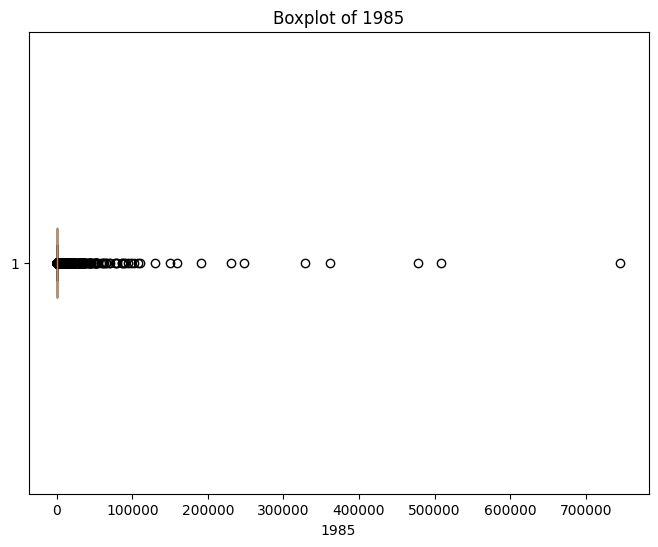

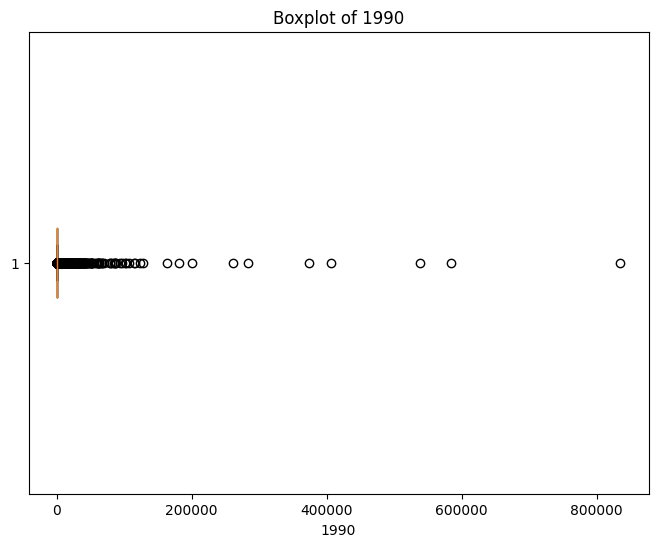

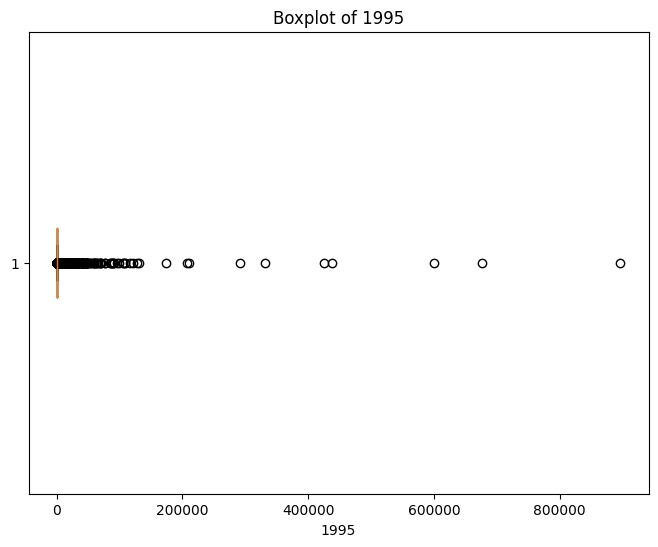

In [0]:
import matplotlib.pyplot as plt

# Select the columns for visualization
selected_columns = ['1985', '1990', '1995']

# Iterate through each selected column and create a box plot
for column in selected_columns:
    # Convert the column to a Pandas series for plotting
    data = attainment.select(column).dropna().toPandas()[column]
    
    # Create a box plot
    plt.figure(figsize=(8, 6))
    plt.boxplot(data, vert=False)
    plt.xlabel(column)
    plt.title(f'Boxplot of {column}')
    plt.show()

In [0]:
# Define the path to save the DataFrame within the mounted storage
output_path = "/mnt/IkigaiGuide/ikigai-transformed-data/attainment"

# Write the updated DataFrame as a CSV file to the mounted Blob Storage
attainment.coalesce(1).write.mode("overwrite").option("header", "true").csv(output_path)

In [0]:
# Adjusted file path to point to the specific file inside the ikigai-raw-data folder
file_path = "/mnt/IkigaiGuide/ikigai-raw-data/school_and_country.csv"

# Load the dataset
school_and_country = spark.read.option("header", "true").option("inferSchema", "true").csv(file_path)

# Display the first few rows of the DataFrame to understand its structure
school_and_country.show()

+--------------------+--------------------+
|         school_name|             country|
+--------------------+--------------------+
|  Harvard University|United States of ...|
|California Instit...|United States of ...|
|Massachusetts Ins...|United States of ...|
| Stanford University|United States of ...|
|Princeton University|United States of ...|
|University of Cam...|      United Kingdom|
|University of Oxford|      United Kingdom|
|University of Cal...|United States of ...|
|Imperial College ...|      United Kingdom|
|     Yale University|United States of ...|
|University of Cal...|United States of ...|
|University of Chi...|United States of ...|
|Johns Hopkins Uni...|United States of ...|
|  Cornell University|United States of ...|
|ETH Zurich – Swis...|         Switzerland|
|University of Mic...|United States of ...|
|University of Tor...|              Canada|
| Columbia University|United States of ...|
|University of Pen...|United States of ...|
|Carnegie Mellon U...|United Sta

In [0]:
school_and_country.describe().show()

+-------+--------------------+--------------------+
|summary|         school_name|             country|
+-------+--------------------+--------------------+
|  count|                 818|                 818|
|   mean|                NULL|                NULL|
| stddev|                NULL|                NULL|
|    min|AGH University of...|           Argentina|
|    max|   Örebro University|United States of ...|
+-------+--------------------+--------------------+



In [0]:
school_and_country.dtypes

[('school_name', 'string'), ('country', 'string')]

In [0]:
from pyspark.sql.functions import col, sum

# Count the missing values for each column
missing_values = school_and_country.select([sum(col(column).isNull().cast("int")).alias(column) for column in school_and_country.columns])

# Show the missing values count
missing_values.show()

+-----------+-------+
|school_name|country|
+-----------+-------+
|          0|      0|
+-----------+-------+



In [0]:
# Define the path to save the DataFrame within the mounted storage
output_path = "/mnt/IkigaiGuide/ikigai-transformed-data/school_and_country"

# Write the updated DataFrame as a CSV file to the mounted Blob Storage
school_and_country.coalesce(1).write.mode("overwrite").option("header", "true").csv(output_path)

In [0]:
# Adjusted file path to point to the specific file inside the ikigai-raw-data folder
file_path = "/mnt/IkigaiGuide/ikigai-raw-data/shanghaiData.csv"

# Load the dataset
shanghaiData = spark.read.option("header", "true").option("inferSchema", "true").csv(file_path)

# Display the first few rows of the DataFrame to understand its structure
shanghaiData.show()

+----------+--------------------+-------------+-----------+------+-----+-----+-----+-----+-----+----+
|world_rank|     university_name|national_rank|total_score|alumni|award| hici|   ns|  pub|  pcp|year|
+----------+--------------------+-------------+-----------+------+-----+-----+-----+-----+-----+----+
|         1|  Harvard University|            1|      100.0| 100.0|100.0|100.0|100.0|100.0| 72.4|2005|
|         2|University of Cam...|            1|       73.6|  99.8| 93.4| 53.3| 56.6| 70.9| 66.9|2005|
|         3| Stanford University|            2|       73.4|  41.1| 72.2| 88.5| 70.9| 72.3| 65.0|2005|
|         4|University of Cal...|            3|       72.8|  71.8| 76.0| 69.4| 73.9| 72.2| 52.7|2005|
|         5|Massachusetts Ins...|            4|       70.1|  74.0| 80.6| 66.7| 65.8| 64.3| 53.0|2005|
|         6|California Instit...|            5|       67.1|  59.2| 68.6| 59.8| 65.8| 52.5|100.0|2005|
|         7| Columbia University|            6|       62.3|  79.4| 60.6| 56.1| 54.

In [0]:
shanghaiData.describe().show()

+-------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|summary|        world_rank|    university_name|     national_rank|       total_score|            alumni|             award|              hici|                ns|               pub|               pcp|              year|
+-------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|  count|              4897|               4896|              4896|              1101|              4896|              4895|              4895|              4875|              4895|              4895|              4897|
|   mean|50.351179673321234|               NULL|11.796068796068797|36.383469573115335| 9.161723856209214|7.6919101123596

In [0]:
shanghaiData.dtypes

[('world_rank', 'string'),
 ('university_name', 'string'),
 ('national_rank', 'string'),
 ('total_score', 'double'),
 ('alumni', 'double'),
 ('award', 'double'),
 ('hici', 'double'),
 ('ns', 'double'),
 ('pub', 'double'),
 ('pcp', 'double'),
 ('year', 'int')]

In [0]:
from pyspark.sql.functions import col, sum

missing_values = shanghaiData.select([sum(col(c).isNull().cast("int")).alias(c) for c in shanghaiData.columns])
missing_values.show()

+----------+---------------+-------------+-----------+------+-----+----+---+---+---+----+
|world_rank|university_name|national_rank|total_score|alumni|award|hici| ns|pub|pcp|year|
+----------+---------------+-------------+-----------+------+-----+----+---+---+---+----+
|         0|              1|            1|       3796|     1|    2|   2| 22|  2|  2|   0|
+----------+---------------+-------------+-----------+------+-----+----+---+---+---+----+



In [0]:
# Count the total number of rows
total_rows = shanghaiData.count()

# Get the number of columns
total_columns = len(shanghaiData.columns)

# Print the results
print("Total number of rows:", total_rows)
print("Total number of columns:", total_columns)

Total number of rows: 4897
Total number of columns: 11


In [0]:
missing_university_rows = shanghaiData.filter(col("university_name").isNull())
missing_university_rows.show(truncate=False)

+----------+---------------+-------------+-----------+------+-----+----+----+----+----+----+
|world_rank|university_name|national_rank|total_score|alumni|award|hici|ns  |pub |pcp |year|
+----------+---------------+-------------+-----------+------+-----+----+----+----+----+----+
|99        |NULL           |NULL         |NULL       |NULL  |NULL |NULL|NULL|NULL|NULL|2013|
+----------+---------------+-------------+-----------+------+-----+----+----+----+----+----+



In [0]:
clean_data = shanghaiData.filter(~col("university_name").isNull())

In [0]:
missing_values = clean_data.select([sum(col(c).isNull().cast("int")).alias(c) for c in clean_data.columns])
missing_values.show()

+----------+---------------+-------------+-----------+------+-----+----+---+---+---+----+
|world_rank|university_name|national_rank|total_score|alumni|award|hici| ns|pub|pcp|year|
+----------+---------------+-------------+-----------+------+-----+----+---+---+---+----+
|         0|              0|            0|       3795|     0|    1|   1| 21|  1|  1|   0|
+----------+---------------+-------------+-----------+------+-----+----+---+---+---+----+



In [0]:
missing_award_rows = shanghaiData.filter(col("award").isNull())
missing_award_rows.show(truncate=False)

+----------+--------------------+-------------+-----------+------+-----+----+----+----+----+----+
|world_rank|university_name     |national_rank|total_score|alumni|award|hici|ns  |pub |pcp |year|
+----------+--------------------+-------------+-----------+------+-----+----+----+----+----+----+
|201-300   |University of Oregon|86-109       |NULL       |9.0   |NULL |NULL|NULL|NULL|NULL|2012|
|99        |NULL                |NULL         |NULL       |NULL  |NULL |NULL|NULL|NULL|NULL|2013|
+----------+--------------------+-------------+-----------+------+-----+----+----+----+----+----+



In [0]:
shanghaiData = shanghaiData.filter((col("award").isNotNull()) & (col("university_name").isNotNull()))

In [0]:
shanghaiData.show(truncate=False)

+----------+-------------------------------------------+-------------+-----------+------+-----+-----+-----+-----+-----+----+
|world_rank|university_name                            |national_rank|total_score|alumni|award|hici |ns   |pub  |pcp  |year|
+----------+-------------------------------------------+-------------+-----------+------+-----+-----+-----+-----+-----+----+
|1         |Harvard University                         |1            |100.0      |100.0 |100.0|100.0|100.0|100.0|72.4 |2005|
|2         |University of Cambridge                    |1            |73.6       |99.8  |93.4 |53.3 |56.6 |70.9 |66.9 |2005|
|3         |Stanford University                        |2            |73.4       |41.1  |72.2 |88.5 |70.9 |72.3 |65.0 |2005|
|4         |University of California, Berkeley         |3            |72.8       |71.8  |76.0 |69.4 |73.9 |72.2 |52.7 |2005|
|5         |Massachusetts Institute of Technology (MIT)|4            |70.1       |74.0  |80.6 |66.7 |65.8 |64.3 |53.0 |2005|


In [0]:
from pyspark.sql.functions import col, sum

missing_values = shanghaiData.select([sum(col(c).isNull().cast("int")).alias(c) for c in shanghaiData.columns])
missing_values.show()

+----------+---------------+-------------+-----------+------+-----+----+---+---+---+----+
|world_rank|university_name|national_rank|total_score|alumni|award|hici| ns|pub|pcp|year|
+----------+---------------+-------------+-----------+------+-----+----+---+---+---+----+
|         0|              0|            0|       3794|     0|    0|   0| 20|  0|  0|   0|
+----------+---------------+-------------+-----------+------+-----+----+---+---+---+----+



In [0]:
from pyspark.sql.functions import mean

# Calculate the mean of the "ns" column
mean_value = shanghaiData.select(mean(col("ns"))).collect()[0][0]

# Fill the missing values in the "ns" column with the mean value
shanghaiData = shanghaiData.fillna(mean_value, subset=["ns"])

In [0]:
from pyspark.sql.functions import col, sum

# Remove rows with missing values in "award" and "university_name" columns
shanghaiData = shanghaiData.filter((col("award").isNotNull()) & (col("university_name").isNotNull()))

# Count missing values in each column
missing_values = shanghaiData.select([sum(col(c).isNull().cast("int")).alias(c) for c in shanghaiData.columns])
missing_values.show()

+----------+---------------+-------------+-----------+------+-----+----+---+---+---+----+
|world_rank|university_name|national_rank|total_score|alumni|award|hici| ns|pub|pcp|year|
+----------+---------------+-------------+-----------+------+-----+----+---+---+---+----+
|         0|              0|            0|       3794|     0|    0|   0|  0|  0|  0|   0|
+----------+---------------+-------------+-----------+------+-----+----+---+---+---+----+



In [0]:
# Count the total number of rows
total_rows = shanghaiData.count()

# Get the number of columns
total_columns = len(shanghaiData.columns)

# Print the results
print("Total number of rows:", total_rows)
print("Total number of columns:", total_columns)

Total number of rows: 4895
Total number of columns: 11


In [0]:
# Define the path to save the DataFrame within the mounted storage
output_path = "/mnt/IkigaiGuide/ikigai-transformed-data/shanghaiData"

# Write the updated DataFrame as a CSV file to the mounted Blob Storage
shanghaiData.coalesce(1).write.mode("overwrite").option("header", "true").csv(output_path)

In [0]:
# Adjusted file path to point to the specific file inside the ikigai-raw-data folder
file_path = "/mnt/IkigaiGuide/ikigai-raw-data/times2011.csv"

# Load the dataset
times2011 = spark.read.option("header", "true").option("inferSchema", "true").csv(file_path)

# Display the first few rows of the DataFrame to understand its structure
times2011.show()

+----------+--------------------+--------------------+--------+-------------+--------+---------+------+-----------+------------+-------------------+----------------------+-----------------+----+
|world_rank|     university_name|             country|teaching|international|research|citations|income|total_score|num_students|student_staff_ratio|international_students|female_male_ratio|year|
+----------+--------------------+--------------------+--------+-------------+--------+---------+------+-----------+------------+-------------------+----------------------+-----------------+----+
|         1|  Harvard University|United States of ...|    99.7|         72.4|    98.7|     98.8|  34.5|       96.1|      20,152|                8.9|                   25%|             NULL|2011|
|         2|California Instit...|United States of ...|    97.7|         54.6|    98.0|     99.9|  83.7|       96.0|       2,243|                6.9|                   27%|          33 : 67|2011|
|         3|Massachusetts

In [0]:
times2011.describe().show()

+-------+-----------------+--------------------+-------------+-----------------+------------------+------------------+------------------+-----------------+------------------+-----------------+-------------------+----------------------+-----------------+------------------+
|summary|       world_rank|     university_name|      country|         teaching|     international|          research|         citations|           income|       total_score|     num_students|student_staff_ratio|international_students|female_male_ratio|              year|
+-------+-----------------+--------------------+-------------+-----------------+------------------+------------------+------------------+-----------------+------------------+-----------------+-------------------+----------------------+-----------------+------------------+
|  count|             2603|                2603|         2603|             2603|              2603|              2603|              2603|             2603|              2603|       

In [0]:
times2011.dtypes


[('world_rank', 'string'),
 ('university_name', 'string'),
 ('country', 'string'),
 ('teaching', 'double'),
 ('international', 'string'),
 ('research', 'double'),
 ('citations', 'double'),
 ('income', 'string'),
 ('total_score', 'string'),
 ('num_students', 'string'),
 ('student_staff_ratio', 'double'),
 ('international_students', 'string'),
 ('female_male_ratio', 'string'),
 ('year', 'int')]

In [0]:
# Count the number of rows in the updated_times2011 DataFrame
row_count = times2011.count()
row_count

2603

In [0]:
from pyspark.sql.functions import col, sum

missing_values = times2011.select([sum(col(c).isNull().cast("int")).alias(c) for c in times2011.columns])
missing_values.show()

+----------+---------------+-------+--------+-------------+--------+---------+------+-----------+------------+-------------------+----------------------+-----------------+----+
|world_rank|university_name|country|teaching|international|research|citations|income|total_score|num_students|student_staff_ratio|international_students|female_male_ratio|year|
+----------+---------------+-------+--------+-------------+--------+---------+------+-----------+------------+-------------------+----------------------+-----------------+----+
|         0|              0|      0|       0|            0|       0|        0|     0|          0|          59|                 59|                    67|              233|   0|
+----------+---------------+-------+--------+-------------+--------+---------+------+-----------+------------+-------------------+----------------------+-----------------+----+



In [0]:
from pyspark.sql.functions import col

# Check the distinct values in the "female_male_ratio" column
distinct_ratios = times2011.select(col("female_male_ratio")).distinct()

# Count the occurrences of each distinct value
value_counts = distinct_ratios.groupBy("female_male_ratio").count().orderBy("count", ascending=False)

# Display the distinct values and their counts
value_counts.show()

+-----------------+-----+
|female_male_ratio|count|
+-----------------+-----+
|          37 : 63|    1|
|          71 : 29|    1|
|          63 : 37|    1|
|          29 : 71|    1|
|          23 : 77|    1|
|          52 : 48|    1|
|          70 : 30|    1|
|          66 : 34|    1|
|          20 : 80|    1|
|          12 : 88|    1|
|          38 : 62|    1|
|          30 : 70|    1|
|             NULL|    1|
|          34 : 66|    1|
|          64 : 36|    1|
|          42 : 58|    1|
|           1 : 99|    1|
|          22 : 78|    1|
|          50 : 50|    1|
|          47 : 53|    1|
+-----------------+-----+
only showing top 20 rows



In [0]:
from pyspark.sql.functions import col

# Calculate the mode of the "female_male_ratio" column
mode_values = times2011.groupBy("female_male_ratio").count().orderBy(col("count").desc())
mode_value = mode_values.first()["female_male_ratio"]

# If mode_value is None, it means there are no unique mode values
# In this case, we'll replace missing values with "Not Available" string
if mode_value is None:
    mode_value = "Not Available"

# Fill the missing values in the "female_male_ratio" column with the mode value
updated_times2011 = times2011.fillna(mode_value, subset=["female_male_ratio"])

In [0]:
# Count the number of rows in the updated_times2011 DataFrame
row_count = updated_times2011.count()
row_count

2603

In [0]:
# Define the path to save the DataFrame within the mounted storage
output_path = "/mnt/IkigaiGuide/ikigai-transformed-data/updated_times2011"

# Write the updated DataFrame as a CSV file to the mounted Blob Storage
updated_times2011.coalesce(1).write.mode("overwrite").option("header", "true").csv(output_path)